In [1]:
import os
import warnings

os.environ['CUDA_VISIBLE_DEVICES'] = ''
warnings.filterwarnings('ignore')

In [2]:
import malaya_speech
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import malaya_speech.augmentation.waveform as augmentation
import random

In [1]:
from glob import glob
from collections import defaultdict

In [2]:
combined = glob('split-speaker-8k-train/combined/*.wav')
len(combined)

49512

In [8]:
def get_data(combined_path, speakers_size = 4, sr = 8000):
    combined, _ = malaya_speech.load(combined_path, sr = sr, scale = False)
    y = []
    for i in range(speakers_size):
        y_, _ = malaya_speech.load(combined_path.replace('combined', str(i)), sr = sr, scale = False)
        y.append(y_)
    return combined, y

In [15]:
# combined, y = get_data(combined[0])
# plt.plot(combined)
# plt.plot(y[2])

In [16]:
librispeech = glob('../speech-bahasa/LibriSpeech/*/*/*/*.flac')
len(librispeech)


def get_speaker_librispeech(file):
    return file.split('/')[-1].split('-')[0]


speakers = defaultdict(list)
for f in librispeech:
    speakers[get_speaker_librispeech(f)].append(f)

vctk = glob('vtck/**/*.flac', recursive = True)
vctk_speakers = defaultdict(list)
for f in vctk:
    s = f.split('/')[-1].split('_')[0]
    vctk_speakers[s].append(f)

files = glob('../speech-bahasa/ST-CMDS-20170001_1-OS/*.wav')
speakers_mandarin = defaultdict(list)
for f in files:
    speakers_mandarin[f[:-9]].append(f)
len(speakers_mandarin)

speakers_malay = {}
speakers_malay['salina'] = glob(
    '../youtube/malay2/salina/output-wav-salina/*.wav'
)
male = glob('../youtube/malay2/turki/output-wav-turki/*.wav')
male.extend(
    glob(
        '../youtube/malay/dari-pasentran-ke-istana/output-wav-dari-pasentran-ke-istana/*.wav'
    )
)
speakers_malay['male'] = male
speakers_malay['haqkiem'] = glob('/home/husein/speech-bahasa/haqkiem/*.wav')
husein = glob('/home/husein/speech-bahasa/audio-wattpad/*.wav')
husein.extend(glob('/home/husein/speech-bahasa/audio-iium/*.wav'))
husein.extend(glob('/home/husein/speech-bahasa/audio/*.wav'))
speakers_malay['husein'] = husein

sr = 8000
speakers_size = 4

s = {**speakers, **vctk_speakers, **speakers_malay, **speakers_mandarin}

keys = list(s.keys())

In [17]:
def random_speakers(n):
    ks = random.sample(keys, n)
    r = []
    for k in ks:
        r.append(random.choice(s[k]))
    return r


def read_wav(f):
    return malaya_speech.load(f, sr = sr)


def random_sampling(s, length):
    return augmentation.random_sampling(s, sr = sr, length = length)


def to_mel(y):
    mel = malaya_speech.featurization.universal_mel(y)
    mel[mel <= np.log(1e-2)] = np.log(1e-2)
    return mel


def combine_speakers(files, n = 5, limit = 4):
    w_samples = random.sample(files, n)
    w_samples = [read_wav(f)[0] for f in w_samples]
    w_lens = [len(w) / sr for w in w_samples]
    w_lens = int(min(min(w_lens) * 1000, random.randint(1000, 5000)))
    w_samples = [random_sampling(w, length = w_lens) for w in w_samples]
    y = [w_samples[0]]
    left = w_samples[0].copy()

    combined = None

    for i in range(1, n):
        right = w_samples[i].copy()
        overlap = random.uniform(0.98, 1.0)
        len_overlap = int(overlap * len(right))
        minus = len(left) - len_overlap
        if minus < 0:
            minus = 0
        padded_right = np.pad(right, (minus, 0))
        left = np.pad(left, (0, len(padded_right) - len(left)))

        left = left + padded_right

        if i >= (limit - 1):
            if combined is None:
                combined = padded_right
            else:
                combined = np.pad(
                    combined, (0, len(padded_right) - len(combined))
                )
                combined += padded_right

        else:
            y.append(padded_right)

    if combined is not None:
        y.append(combined)

    # for i in range(len(y)):
    #     if len(y[i]) != len(left):
    #         y[i] = np.pad(y[i], (0, len(left) - len(y[i])))
    #         y[i] = y[i] / np.max(np.abs(y[i]))

    # left = left / np.max(np.abs(left))
    
    maxs = [max(left)]
    for i in range(len(y)):
        if len(y[i]) != len(left):
            y[i] = np.pad(y[i], (0, len(left) - len(y[i])))
            maxs.append(max(y[i]))

    max_amp = max(maxs)
    mix_scaling = 1 / max_amp * 0.90
    left = left * mix_scaling

    for i in range(len(y)):
        y[i] = y[i] * mix_scaling

    return left, y

In [18]:
count = speakers_size
combined, y = combine_speakers(random_speakers(count), count)

In [19]:
len(y)

4

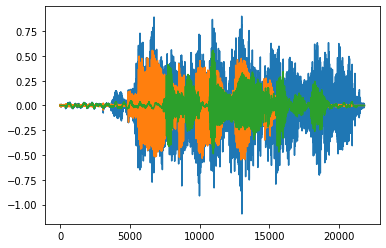

In [20]:
plt.plot(combined)
plt.plot(y[0])
plt.plot(y[1])

In [21]:
directory = 'split-speaker-8k-train'
!mkdir {directory}
!mkdir {directory}/combined

mkdir: cannot create directory ‘split-speaker-8k-train’: File exists
mkdir: cannot create directory ‘split-speaker-8k-train/combined’: File exists


In [22]:
for i in range(speakers_size):
    os.system(f'mkdir {directory}/{i}')

In [23]:
from tqdm import tqdm
import soundfile as sf

for i in tqdm(range(50000)):
    try:
        combined, y = combine_speakers(random_speakers(count), count)
        sf.write(f'{directory}/combined/{i}.wav', combined, samplerate = sr)
        for k in range(speakers_size):
            sf.write(f'{directory}/{k}/{i}.wav', y[k], samplerate = sr)
    except:
        pass

100%|██████████| 50000/50000 [40:32<00:00, 20.55it/s]  


In [24]:
directory = 'split-speaker-8k-test'
!mkdir {directory}
!mkdir {directory}/combined

In [25]:
for i in range(speakers_size):
    os.system(f'mkdir {directory}/{i}')

In [26]:
from tqdm import tqdm
import soundfile as sf

for i in tqdm(range(100)):
    try:
        combined, y = combine_speakers(random_speakers(count), count)
        sf.write(f'{directory}/combined/{i}.wav', combined, samplerate = sr)
        for k in range(speakers_size):
            sf.write(f'{directory}/{k}/{i}.wav', y[k], samplerate = sr)
    except:
        pass

100%|██████████| 100/100 [00:04<00:00, 23.49it/s]
